In [1]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import shap
from matplotlib import pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

In [9]:
try:
    with open('dataset.pickle', 'rb') as f:
        print('Loaded cached dataset')
        X, y, display_data, feature_names, n_features, n_samples = pickle.load(f)
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [10]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


In [19]:
try:
    with open('predictions.pickle', 'rb') as f:
        X_clean, display_data_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
        print('Loaded cached predictions')
except FileNotFoundError:
    print('No cached predictions found')

Loaded cached predictions


## Load Data

In [2]:
X, y = shap.datasets.adult()
display_data = shap.datasets.adult(display=True)[0].values
feature_names = np.array(X.columns)
n_features = len(feature_names)
n_samples = X.shape[0]
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, y, display_data, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=52)

## Train Models

TODO: https://scikit-learn.org/stable/modules/calibration.html

In [5]:
%%time
clf_a = LogisticRegression(C=1.0, max_iter=10000)
clf_a.fit(X_train, y_train)
clf_b = xgb.XGBClassifier(nestimators=100, max_depth=2)
clf_b.fit(X_train, y_train)
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:31:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { nestimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:31:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 15.9 s, sys: 1.27 s, total: 17.1 s
Wall time: 10.8 s


## Analyze Performance

In [6]:
pred_test_a = clf_a.predict(X_test)
pred_test_b = clf_b.predict(X_test)

In [7]:
print(classification_report(pred_test_a, y_test))

              precision    recall  f1-score   support

       False       0.94      0.87      0.90      5364
        True       0.54      0.73      0.62      1149

    accuracy                           0.84      6513
   macro avg       0.74      0.80      0.76      6513
weighted avg       0.87      0.84      0.85      6513



In [8]:
print(classification_report(pred_test_b, y_test))

              precision    recall  f1-score   support

       False       0.95      0.89      0.92      5296
        True       0.62      0.80      0.70      1217

    accuracy                           0.87      6513
   macro avg       0.79      0.84      0.81      6513
weighted avg       0.89      0.87      0.88      6513



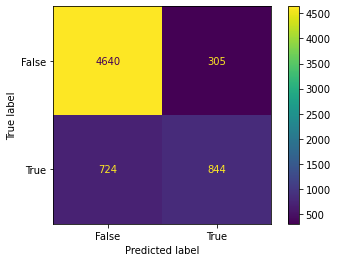

In [9]:
cm = confusion_matrix(y_test, pred_test_a, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
disp.plot();

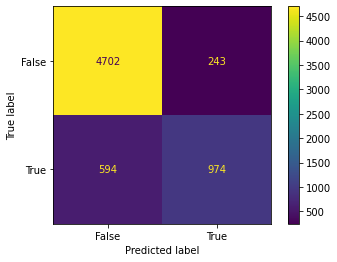

In [10]:
cm = confusion_matrix(y_test, pred_test_b, labels=clf_b.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_b.classes_)
disp.plot();

In [11]:
proba_test_a = clf_a.predict_proba(X_test)[:, 1]
proba_test_b = clf_b.predict_proba(X_test)[:, 1]
fpr_a, tpr_a, _ = roc_curve(y_test, proba_test_a)
fpr_b, tpr_b, _ = roc_curve(y_test, proba_test_b)

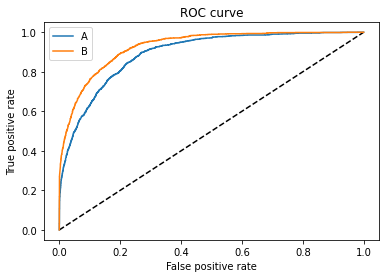

In [12]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_a, tpr_a, label='A')
plt.plot(fpr_b, tpr_b, label='B')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [13]:
roc_auc_score(y_test, proba_test_a)

0.8920452141928562

In [14]:
roc_auc_score(y_test, proba_test_b)

0.9280031236458183

## Visualize Distributions of Predictions

In [22]:
log_proba_from_proba = lambda p: np.log(p)
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = log_proba_from_proba(clf_b.predict_proba(X))
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)
X_clean = X[is_finite]
display_data_clean = display_data[is_finite]

n_samples_clean = X_clean.shape[0]
indices = np.array(range(n_samples_clean))
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
proba_a = clf_a.predict_proba(X)
proba_b = clf_b.predict_proba(X)
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = log_proba_from_proba(clf_b.predict_proba(X))
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

with open('predictions.pickle', 'wb') as f:
    pickle.dump((X_clean, display_data_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b), f, pickle.HIGHEST_PROTOCOL)

Instances with non-finite log-odds predictions:

In [17]:
pd.DataFrame(X[~is_finite]).describe()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


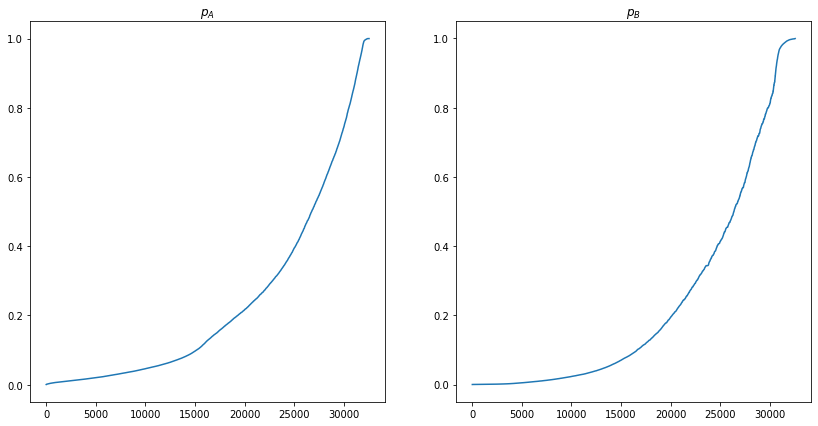

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

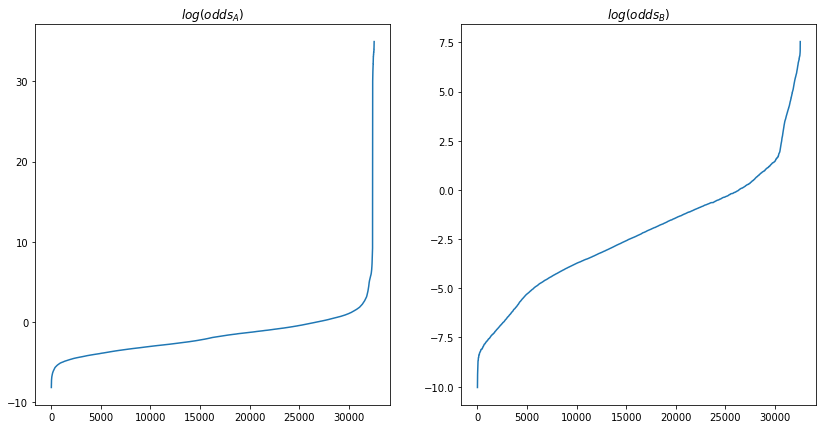

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

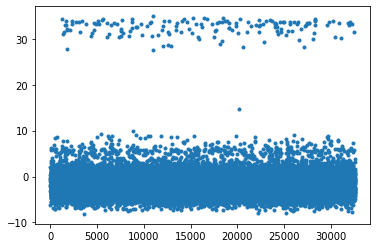

In [20]:
plt.scatter(indices, log_odds_a, marker='.');

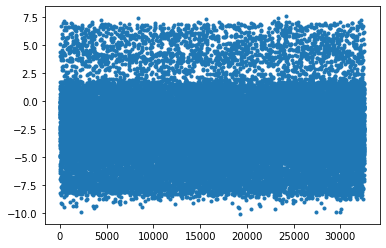

In [21]:
plt.scatter(indices, log_odds_b, marker='.');